# Comparing naplib TRF to STRFLab

In this notebook we compare STRF models fit with naplib-python to those produced by STRFLab in Matlab

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import naplib as nl

In [2]:
filepath = '../out_structs/out_struct_sample.mat'
out = nl.io.import_out_struct(filepath)
print(f'This data has {len(out)} trials')

This data has 18 trials


In [3]:
# corresponding STRFlab strfs
from hdf5storage import loadmat
strflab = loadmat('../out_structs/STRFLab_predictions_LIJ120clean.mat')
strflab['strf_cell'] = strflab['strf_cell'].squeeze()
strflab['strf_preds'] = strflab['strf_preds'].squeeze()
strflab['strf_corrs'] = strflab['strf_corrs'].squeeze()



In [4]:
# This data contains the fields 'aud' and 'resp', which give the stimulus and neural responses
print(f"aud stimulus shape for first trial : {data[0]['aud'].shape}")
print(f"response shape for first trial : {data[0]['resp'].shape}")

aud stimulus shape for first trial : (6047, 23)
response shape for first trial : (6047, 30)


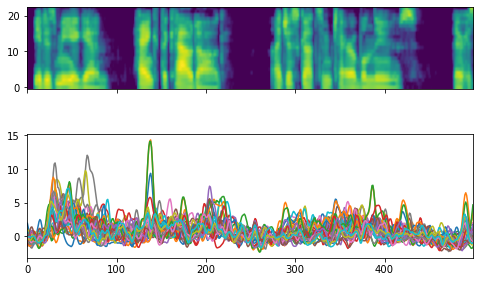

In [5]:
# Let's look at the first 5 seconds more closely

fig, axes = plt.subplots(2,1,figsize=(8,5), sharex=True)
axes[0].imshow(data[0]['aud'][:500].T, origin='lower', aspect=4)

axes[1].plot(data[0]['resp'][:500])
plt.show()

## Fit STRFs

Fit STRF models that have a receptive field of 400 ms in the past

In [6]:
tmin = 0 # receptive field begins at time=0
tmax = 0.4 # receptive field ends at a lag of 0.4 seconds
sfreq = 100 # sampling frequency of data

strf_model = nl.encoding.TRF(tmin, tmax, sfreq)


In [7]:
# I we want to first, we can normalize the responses
# data['resp'] = nl.preprocessing.normalize(data=data, field='resp')

In [8]:
# train model on the first 16 trials 
data_train = data[:16]
data_test = data[16:]

### Fit STRFs with default model params

- 'Ridge' regularization, default set of alphas

In [9]:
# Now, fit the model to the training data. This model with contain
# 30 STRFs, one for each output channel in resp

strf_model.fit(data=data_train, X='aud', y='resp')


100%|██████████| 30/30 [02:11<00:00,  4.38s/it]


TRF(alpha=[100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0,
           1000000000.0],
    sfreq=100.0, tmax=0.4, tmin=0)

### Fit STRFs with different regularization

- 'Laplacian' regularization, modified range of alphas

In [10]:
# We can also change things like the regularization type, and even the range of
# regularization alphas for the cross-validation procedure. By default, the
# model is fit with 'ridge' regularization

strf_model_2 = nl.encoding.TRF(tmin, tmax, sfreq, reg_type='laplacian', alpha=np.logspace(2,10,8))
strf_model_2.fit(data=data_train, X='aud', y='resp')


100%|██████████| 30/30 [02:28<00:00,  4.95s/it]


TRF(alpha=array([1.00000000e+02, 1.38949549e+03, 1.93069773e+04, 2.68269580e+05,
       3.72759372e+06, 5.17947468e+07, 7.19685673e+08, 1.00000000e+10]),
    reg_type='laplacian', sfreq=100.0, tmax=0.4, tmin=0)

## Analyze the STRFs

In [11]:
# compute correlation scores for the withheld test data

scores = strf_model.score(data=data_test, X='aud', y='resp')
scores_2 = strf_model_2.score(data=data_test, X='aud', y='resp')

In [26]:
# set the STRFs from STRFlab into the weights for a TRF model
from copy import deepcopy
strf_model_strflab = deepcopy(strf_model)

for elec in range(30):
    tmp = strflab['strf_cell'][elec].squeeze()[np.newaxis,:,:]
    strf_model_strflab.models_[elec].estimator_.coef_ = tmp
    strf_model_strflab.models_[elec].coef_ = tmp
    
scores_strflab = strf_model_strflab.score(data=data_test, X='aud', y='resp')

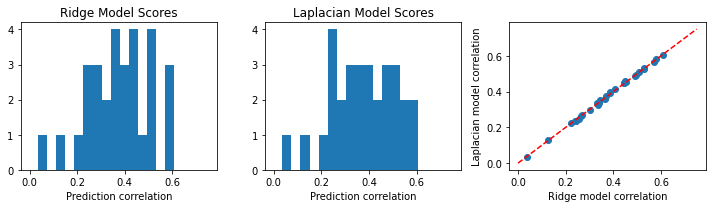

In [27]:
# compare the scores from each model's predictions

fig, axes = plt.subplots(1,3,figsize=(10,3), sharex=True)
axes[0].hist(scores, 15)
axes[0].set_xlabel('Prediction correlation')
axes[0].set_title('Ridge Model Scores')
axes[1].hist(scores_2, 15)
axes[1].set_xlabel('Prediction correlation')
axes[1].set_title('Laplacian Model Scores')
axes[2].scatter(scores, scores_2)
axes[2].set_xlabel('Ridge model correlation')
axes[2].set_ylabel('Laplacian model correlation')
axes[2].plot([0,0.75],[0,0.75],'r--')
plt.tight_layout()
plt.show()


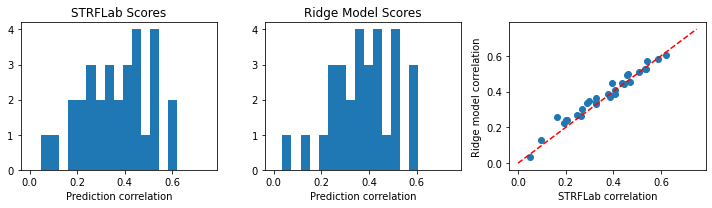

In [42]:
fig, axes = plt.subplots(1,3,figsize=(10,3), sharex=True)
axes[0].hist(scores_strflab, 15)
axes[0].set_xlabel('Prediction correlation')
axes[0].set_title('STRFLab Scores')
axes[1].hist(scores, 15)
axes[1].set_xlabel('Prediction correlation')
axes[1].set_title('Ridge Model Scores')
axes[2].scatter(scores_strflab, scores)
axes[2].set_xlabel('STRFLab correlation')
axes[2].set_ylabel('Ridge model correlation')
axes[2].plot([0,0.75],[0,0.75],'r--')
plt.tight_layout()
plt.show()

In [32]:
# we can access the STRF weights through the .coef_ attribute of the model
coef_ridge = strf_model.coef_
coef_laplacian = strf_model_2.coef_

print(f'STRF shape (num_outputs, frequency, lag) = {coef_ridge.shape}')


STRF shape (num_outputs, frequency, lag) = (30, 23, 40)


### Visualize the STRF for each electrode

We can see that the Laplacian-regularized model gives a smoother STRF

In [33]:
# we can access the STRF weights through the .coef_ attribute of the model
coef_ridge = strf_model.coef_
coef_laplacian = strf_model_2.coef_

print(f'STRF shape (num_outputs, frequency, lag) = {coef_ridge.shape}')

STRF shape (num_outputs, frequency, lag) = (30, 23, 40)


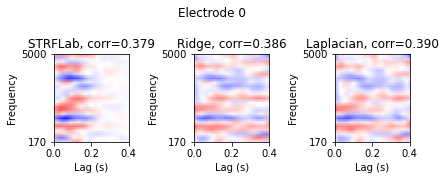

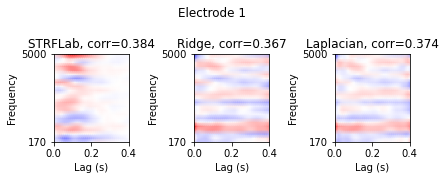

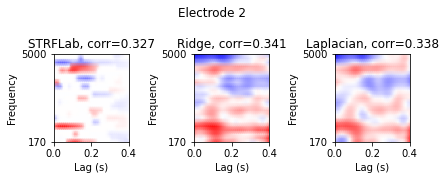

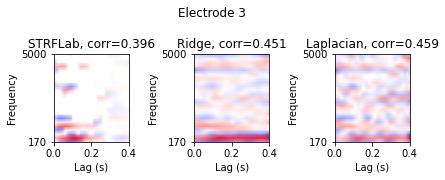

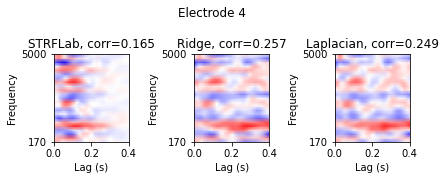

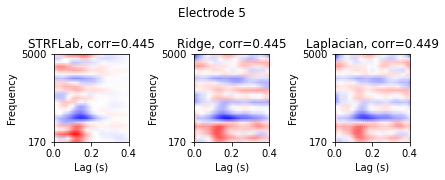

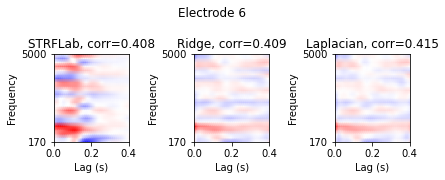

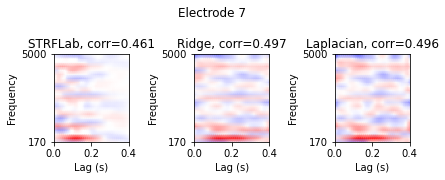

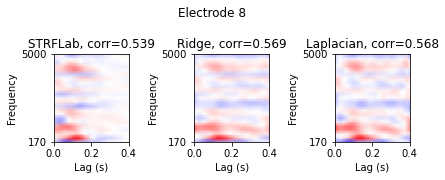

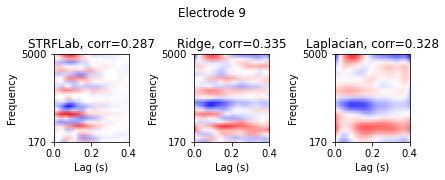

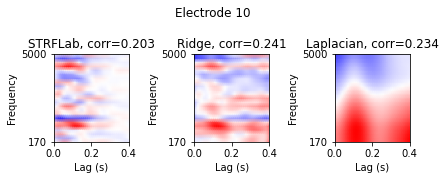

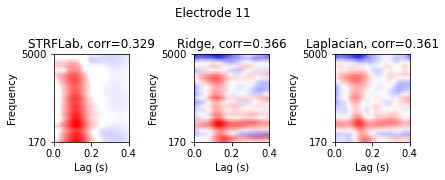

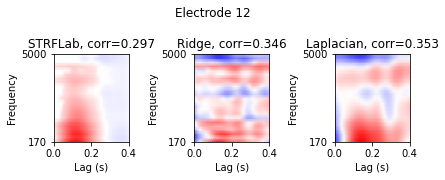

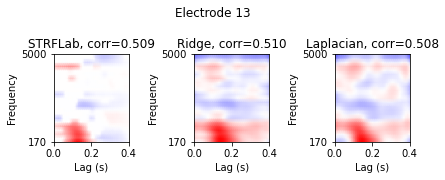

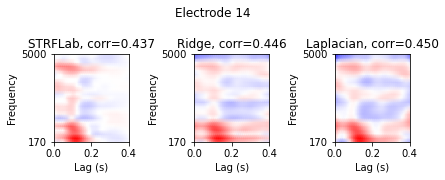

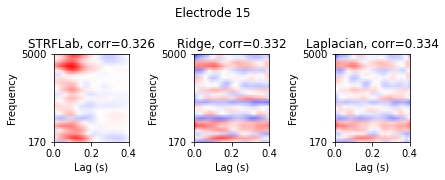

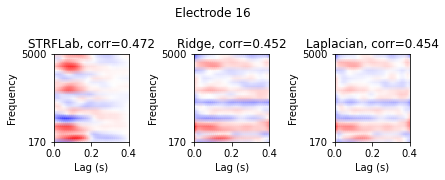

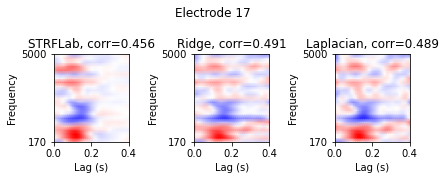

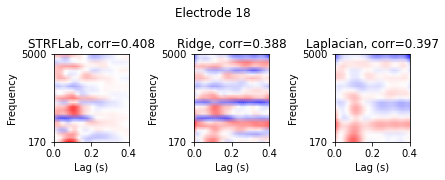

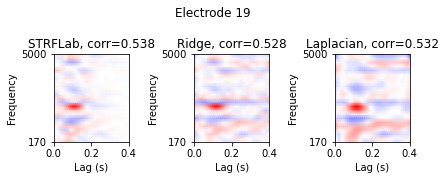

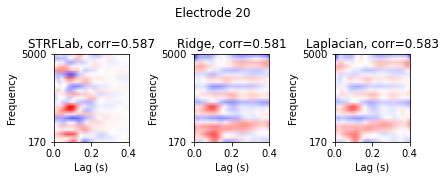

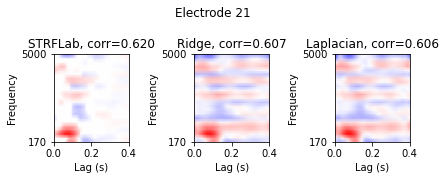

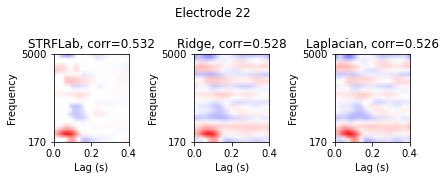

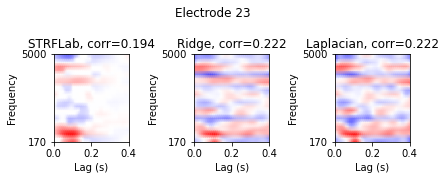

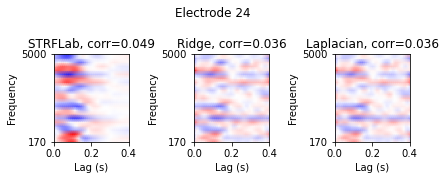

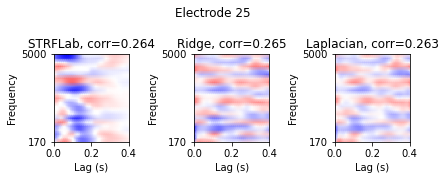

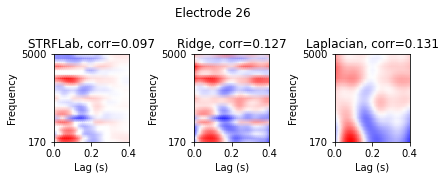

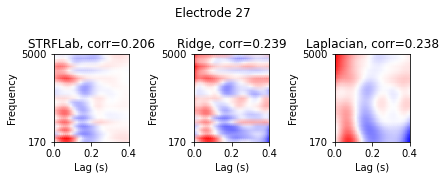

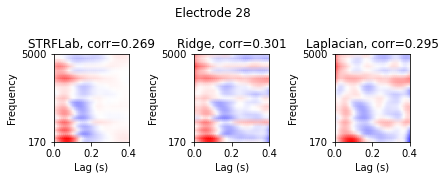

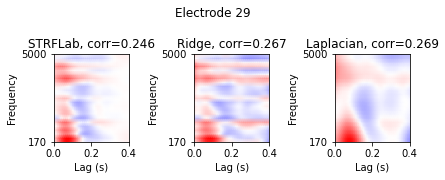

In [38]:
# Now, visualize the STRF weights for each electrode and for each model
from naplib.visualization import imSTRF

freqs = np.array([170, 5000])

for elec, (model_1_coef, model_2_coef, score_model_1, score_model_2) in enumerate(zip(coef_ridge, coef_laplacian, scores, scores_2)):
    fig, axes = plt.subplots(1,3,figsize=(6,2.5))
    imSTRF(strflab['strf_cell'][elec].squeeze(), tmin=tmin, tmax=tmax, freqs=freqs, ax=axes[0])
    axes[0].set_title('STRFLab, corr={:2.3f}'.format(scores_strflab[elec]))
    
    imSTRF(model_1_coef, tmin=tmin, tmax=tmax, freqs=freqs, ax=axes[1])
    axes[1].set_title('Ridge, corr={:2.3f}'.format(score_model_1))
    
    imSTRF(model_2_coef, tmin=tmin, tmax=tmax, freqs=freqs, ax=axes[2])
    axes[2].set_title('Laplacian, corr={:2.3f}'.format(score_model_2))
    
    fig.suptitle(f'Electrode {elec}')
    fig.tight_layout()
    plt.show()
    
    

### Compute and Plot STRF Predictions

We see that the two STRF models have nearly identical predictions for most electrodes

In [17]:
predictions = strf_model.predict(data=data_test, X='aud') # this is a list of the same length as data_test
predictions_2 = strf_model_2.predict(data=data_test, X='aud')

# shapes of predictions for each trial 
print([x.shape for x in predictions])

[(2829, 30), (2836, 30)]


In [39]:
# get predictions from STRFLab model
predictions_strflab = strf_model_strflab.predict(data=data_test, X='aud') # this is a list of the same length as data_test


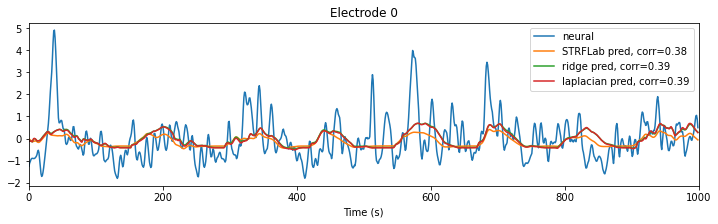

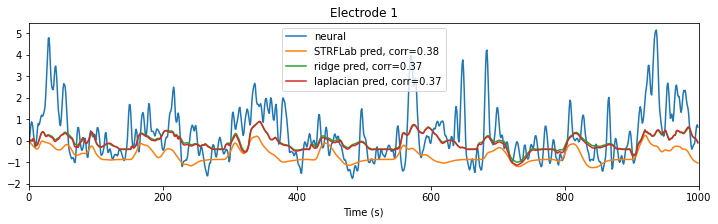

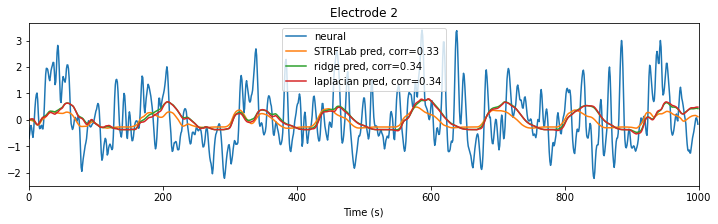

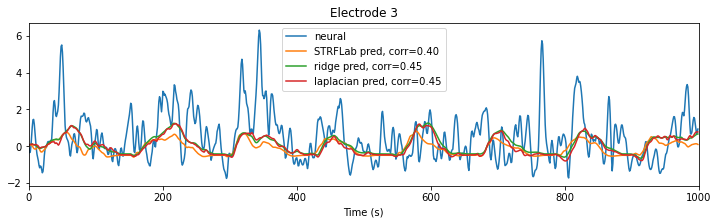

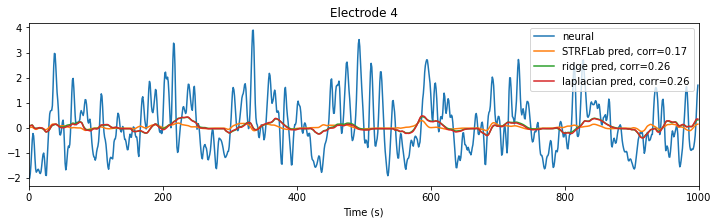

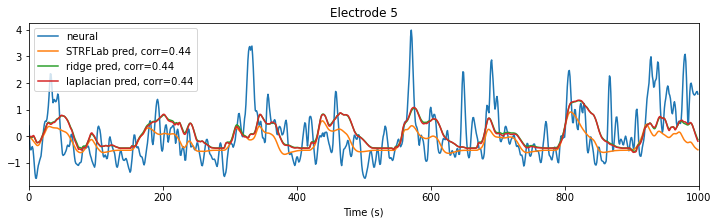

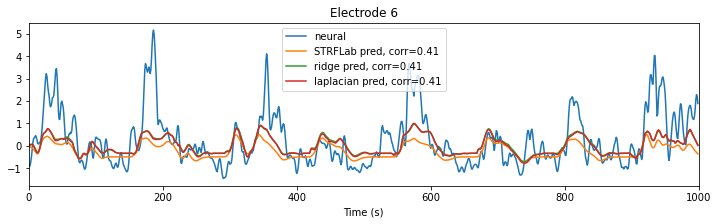

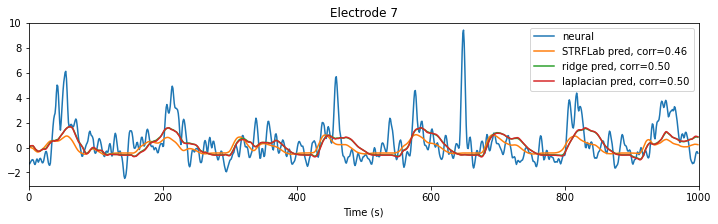

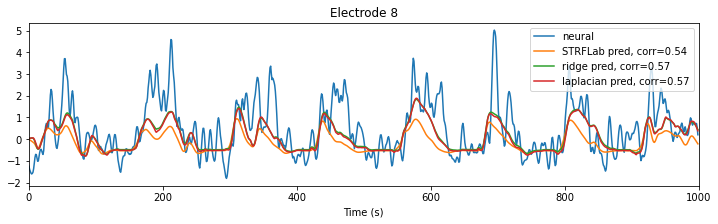

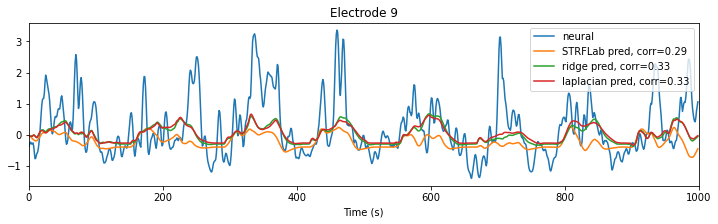

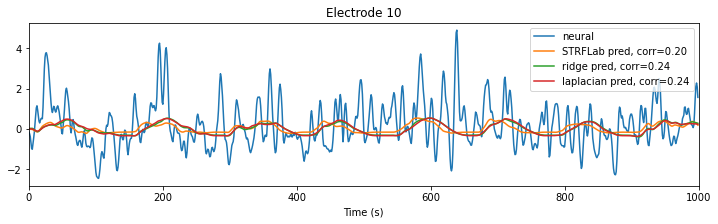

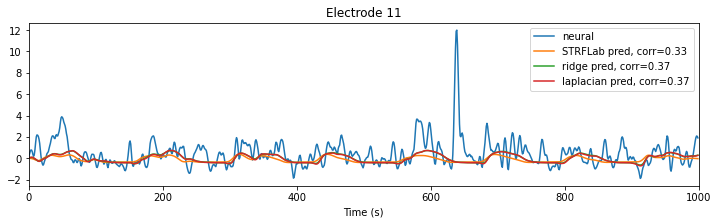

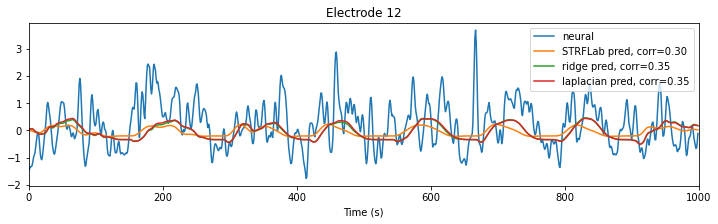

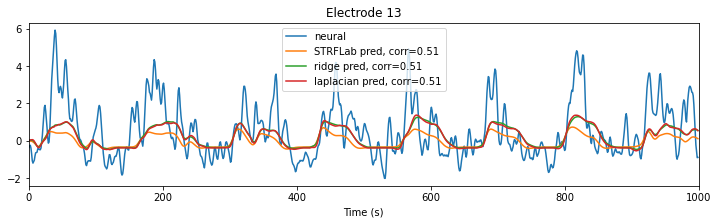

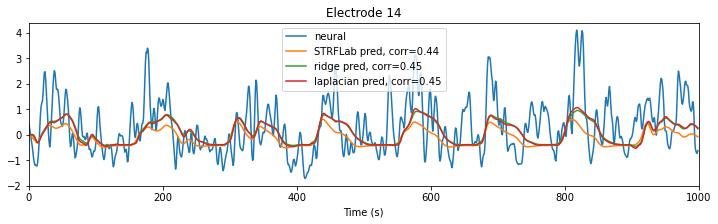

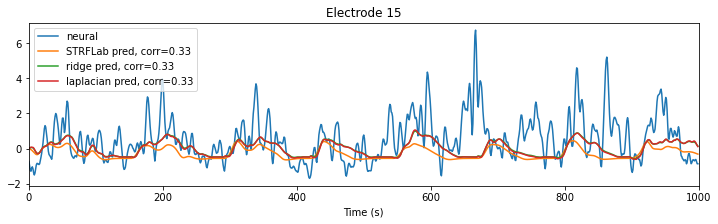

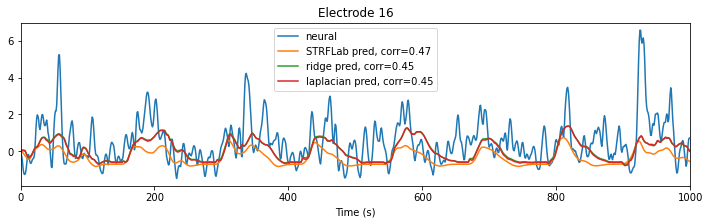

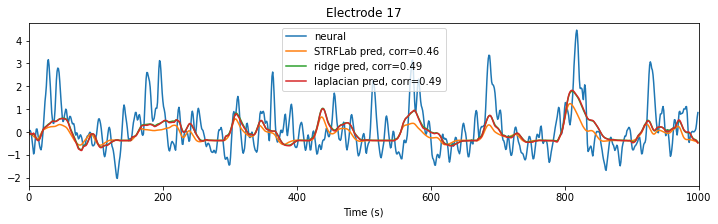

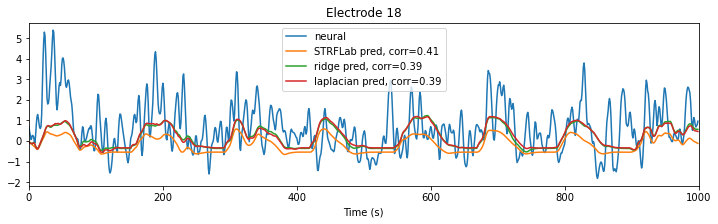

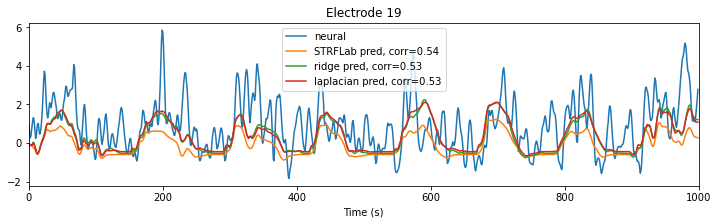

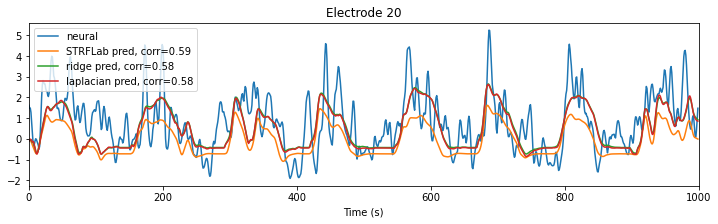

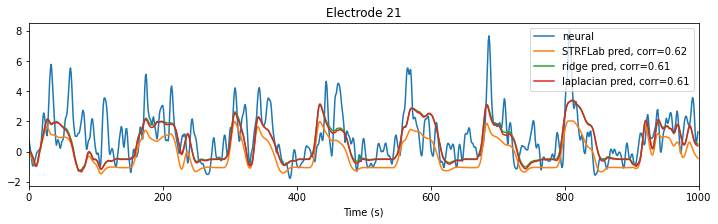

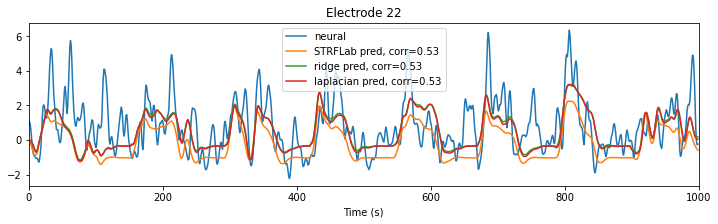

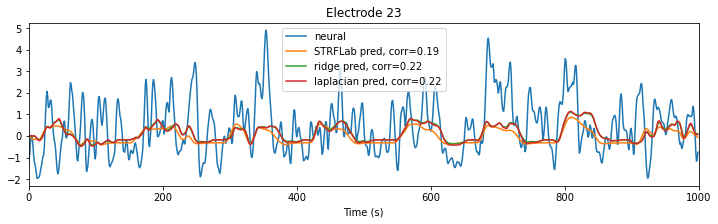

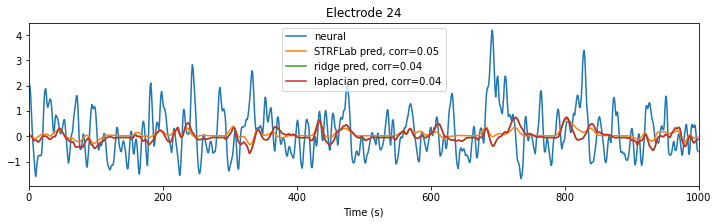

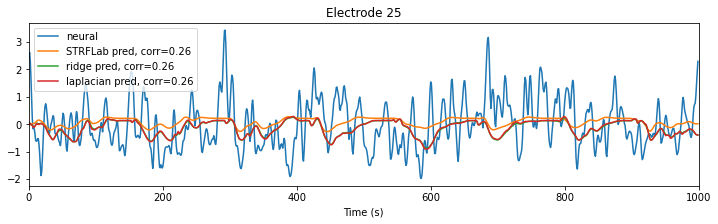

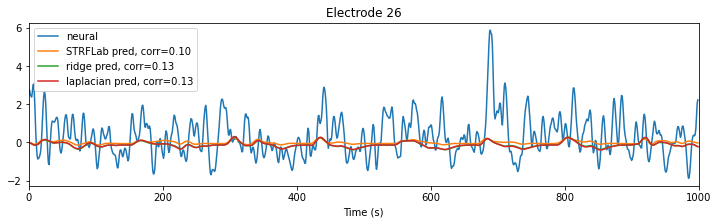

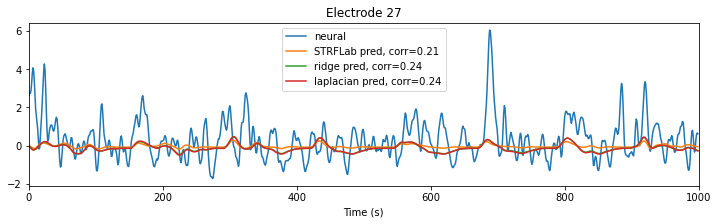

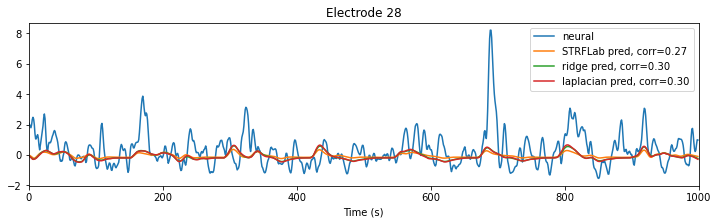

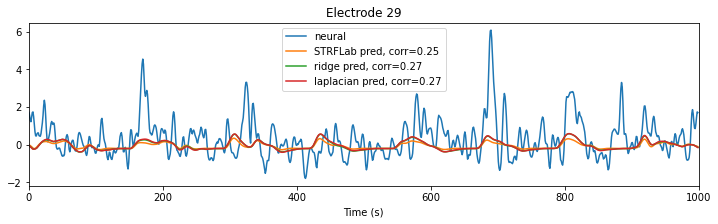

In [41]:
# plot the predictions for the first 10 seconds of the second-to-last trial of test data for each electrode


max_time = 1000

for elec in range(predictions[0].shape[1]):


    plt.figure(figsize=(12,3))
    plt.plot(data_test['resp'][-2][:max_time,elec], label='neural')
    plt.plot(predictions_strflab[-2][:max_time,elec], label='STRFLab pred, corr={:2.2f}'.format(scores_strflab[elec]))

    plt.plot(predictions[-2][:max_time,elec], label='ridge pred, corr={:2.2f}'.format(scores[elec]))
    plt.plot(predictions_2[-2][:max_time,elec], label='laplacian pred, corr={:2.2f}'.format(scores[elec]))
#     plt.xticks([0, 500, 1000], ['0', '5', '10'])
    plt.xlabel('Time (s)')
    plt.legend()
    plt.title(f'Electrode {elec}')
    plt.xlim([0, max_time])
    plt.show()


